In [14]:
import numpy as np

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [16]:
"""
Load the Dataset

"""
dataset = datasets.load_iris()


X = dataset.data
Y = dataset.target

feature_names = dataset.feature_names


class_names = dataset.target_names

class_dict = {i : class_names[i] for i in range(len(class_names))}

print(dataset.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [17]:

"""
Split Dataset into Training and Testing sets
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)


print("Class Dictionary", class_dict)

Class Dictionary {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


In [18]:
import pandas as pd
df = pd.DataFrame(X)
df.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [31]:

"""
Entropy function takes as input, list of labels Y and a list of all possible classes 
It returns the entropy of the current data subset.
"""

def entropy(Y, possible_classes):
    entropy = 0
    total_count = len(Y)
    for y in possible_classes :
        count_y = (Y == y).sum()
        p_i = count_y/total_count
        entropy -=  p_i * np.log(p_i)
    return entropy

"""
info_gain_for_split return inforamation gain of the current split of Y with list of integers splits
ith value of list splits means the ith Y value belongs to that split

lengths of Y and splits are equal

e.g. say Y = 1.2 4.5 3.2 2.3
    splits = 0 1 0 1 
    then 1.2 and 3.2 belong to same group, 4.5 and  2.3 belong to same group
"""

def info_gain_split_info_for_split(Y, splits):
    
    #initialize info_gain and split_info values
    info_gain = 0
    split_info = 0    
    
    # mod_Y is number of examples
    mod_Y = len(Y)
    
    # unique splits are number of groups in which data is divided
    unique_splits = list(set(splits))
    
    
    for s in unique_splits:
        
        # find indices of examples in group s
        indices = (splits == s)
        Y_split_i = Y[indices]
                
        #number of examples in current group s
        mod_Y_i = len(Y_split_i)
        
        """
                                           |Yi|
         ratio_mod_Y_i_to_mod_Y, ratio =   ----
                                           |Y|
        """
        ratio_mod_Y_i_to_mod_Y = (mod_Y_i/mod_Y)
        
        # list of all possible classes in group s
        possible_classes_Y_i = list(set(Y_split_i))
        
        # update info gain and split info values
        info_gain += ((ratio_mod_Y_i_to_mod_Y) * entropy( Y_split_i, possible_classes_Y_i))
        split_info -= (ratio_mod_Y_i_to_mod_Y * np.log(ratio_mod_Y_i_to_mod_Y))
    
    return info_gain, split_info

"""
Considering input data to be continious, split method takes as input X - the data, Y - the labels, 
and feature index on which to split the data

1. find the set of unique values of feature f and sort it
2. build list of mid values ie mean of each pair of adjacent values
3. for each mid value
    3.1 split data into two parts
    3.2 find information gain
    3.3 keep the best split
returns min_info_gain: information gain for best split
        min_split_info : split info for best split
        best_split_labels : list of labels for each example
        mid_value_for_min_info_gain : the mid value for which best split on feature f was made
"""


def split(X, Y, feature):
    # find the set of unique values of feature f and sort it
    possible_values_current_feature = list(set( X[:, feature] ))
    pvcf = possible_values_current_feature
    pvcf.sort()
    
    
    # build list of mid values ie mean of each pair of adjacent values
    mid_values = []
    for i in range(len(possible_values_current_feature) -1 ):
        mid_values.append((pvcf[i] + pvcf[i+1])/2)
    
    # initialize variables
    min_info_gain = np.inf
    mid_value_for_min_info_gain = 0
    min_split_info = 0
    best_split_labels = np.array([])
    
    # iterate over list of mid values
    for value in mid_values:
        current_split_labels = np.ones(len(Y))
        
        # splitting data into two parts, one group belongs to split 0 and other to split 1
        current_split_labels[ X[:, feature] <= value ] = 0
        
        # find information gain and split info for current split
        current_split_information_gain, current_split_split_info = info_gain_split_info_for_split(Y, current_split_labels)
        
        # keep the best split
        if current_split_information_gain < min_info_gain :
            min_info_gain = current_split_information_gain
            mid_value_for_min_info_gain = value
            min_split_info = current_split_split_info
            best_split_labels = current_split_labels
    
    return min_info_gain, min_split_info, best_split_labels.astype(int), mid_value_for_min_info_gain

"""
decision_tree:
    Input:
        X : list of examples
        Y : list of labels
        features : list of indices of features; after each split, one element is removed from this list
        feature_names: list of feature names
        class_dict : dictionary of possible classes indices mapped to class names
        level : level in recursion tree (only used for printing steps)
    
    
    
    Output:
        dictionary of nodes where each node is a decision node used for prediction
"""
    
def decision_tree(X, Y, features, feature_names, class_dict, level):
    # current decision node dictionary
    node = {}
    
    #
    node["level"] = level
    
    # dictionary of classes mapped to respective counts in Y
    class_counts = {}
    print("\nLevel", level)
    possible_classes = list(set(Y))
    
    # max_class is majority class, max_count is count of majority class
    max_count = -np.inf
    max_class = possible_classes[0]
    
    # add key value pairs of classes and their counts in class_counts dictionary
    # also find the majority class 
    for y in possible_classes:
        count_y = (Y == y).sum()
        class_counts[class_dict[y]] = count_y
        print("Count of", class_dict[y], "=", count_y)
        if count_y > max_count :
            max_count = count_y
            max_class = y   
    
    # find current entropy
    current_entropy = entropy(Y, possible_classes)
    print("Current Entropy is =", current_entropy)
    
    # add the class_counts dictionary to node dictionary
    node['class_counts'] = class_counts
    
    # add entropy value to node dictionary
    node["Entropy"] = current_entropy
    
    """
    check for base case, ie either all the examples are marked with a single class
    or
    there is no more feature to split current data
    
    mark this decision node as leaf node
    add the value of predict class to this node
    
    return the node
    """
    
    node["predict_class"] = max_class
    node["num_of_examples"] = len(Y)

    if len(possible_classes) == 1 or len(features) == 0:
        print("Reached leaf Node")
        node["is_leaf"] = True
        return node
    
    """
    else
    this node is NOT a leaf node and splitting can be done
    
    """
    node["is_leaf"] = False
    
    """ initialize few variables
    
    selected_feature : index of selected feature to make split on
    
    max_info_gain : information gain on splitting using the selected_feature
    
    max_split_info : split info on splitting using the selected_feature
    
    best_split_labels : labels assigned to examples
    
    best_split_mid_value : mid value of selected feature to use for prediction
    
    """
    selected_feature = None
    max_info_gain = -np.inf
    max_split_info = -np.inf
    best_split_labels = None
    best_split_mid_value = None
    
    # iterate over all available features
    for f in features:
        
        # find info gain
        # split info
        # current split labels for best split on curent feature 
        # mid value for current feature
        info_gain, split_info, current_split, current_mid_value_for_f = split(X, Y, f)
        #print("info_gain, split_info", info_gain, split_info)
        #print("gain ratio", info_gain/split_info)

        # keep feature that gives maximum gain
        if info_gain > max_info_gain and info_gain < np.inf:
            selected_feature = f
            max_info_gain = info_gain
            max_split_info = split_info
            best_split_labels = current_split
            best_split_mid_value = current_mid_value_for_f

    """
    add index, name of selected feature 
    information gain
    mid value of selected feature
    number of examples at current decision
    to node dictionary
    """
    node["selected_feature"] = feature_names[selected_feature]
    node["selected_feature_index"] = selected_feature
    node["max_info_gain"] = max_info_gain
    node["best_split_mid_value"] = best_split_mid_value
    
    if max_split_info != 0 :
        print("Splitting on feature", "\'" + feature_names[selected_feature] + "\'","with gain ratio", max_info_gain/max_split_info)
    else :
        print("Splitting on feature", "\'" + feature_names[selected_feature] + "\'","with gain ratio inf")
    #splits = split(X, Y, selected_feature)
    
    # find list of groups in which current dataset is divided
    unique_splits = list(set(best_split_labels))
    
    # remove index of selected feature
    selected_feature_index = np.argwhere(features == selected_feature)
    features =  np.delete(features, selected_feature_index)
    
    """
    recursively call decision tree on 'split' datasets
    """
    for s in unique_splits:
        # find indices of examples that belong to split s
        indices = (best_split_labels == s)
        X_split_i = X[indices, :]
        Y_split_i = Y[indices]
        # store the output dictionaries of child splits in current node dictionary
        node[s] = decision_tree(X_split_i, Y_split_i, features, feature_names, class_dict, level + 1)
    """
    return the "decision tree" (dictionary)
    """
    return node

features = np.arange(len(feature_names))
tree_dict = decision_tree(X_train, Y_train, features, feature_names, class_dict, level = 0)


Level 0
Count of setosa = 37
Count of versicolor = 34
Count of virginica = 41
Current Entropy is = 1.09567141291
Splitting on feature 'sepal width (cm)' with gain ratio 1.36236362201

Level 1
Count of setosa = 2
Count of versicolor = 25
Count of virginica = 18
Current Entropy is = 0.831442898105
Splitting on feature 'sepal length (cm)' with gain ratio 3.57288311053

Level 2
Count of setosa = 2
Current Entropy is = 0.0
Reached leaf Node

Level 2
Count of versicolor = 25
Count of virginica = 18
Current Entropy is = 0.679837621186
Splitting on feature 'petal length (cm)' with gain ratio 0.423143569705

Level 3
Count of versicolor = 22
Count of virginica = 1
Current Entropy is = 0.178844912717
Splitting on feature 'petal width (cm)' with gain ratio 0.0

Level 4
Count of versicolor = 22
Current Entropy is = 0.0
Reached leaf Node

Level 4
Count of virginica = 1
Current Entropy is = 0.0
Reached leaf Node

Level 3
Count of versicolor = 3
Count of virginica = 17
Current Entropy is = 0.42270908

In [33]:
def predict_single(X, tree_dict):
    if tree_dict['is_leaf']:
        return tree_dict["predict_class"]
    index = tree_dict["selected_feature_index"]
    feature_value = tree_dict["best_split_mid_value"]

    if X[index] <= feature_value :
        #print(X[index], "<=" ,feature_value)
        return predict_single(X, tree_dict[0])
    else:
        #print(X[index], ">" ,feature_value)
        return predict_single(X, tree_dict[1])
    
def predict(X, tree_dict):
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(predict_single(X[i], tree_dict))
    return Y_pred

def print_dict(dictionary):
    for key in dictionary:
        if isinstance(dictionary[key], dict) :
            print(key, end = " ")
            print_dict(dictionary[key])
        else:
            print(key, dictionary[key])


    

In [34]:
print_dict(tree_dict)

level 0
class_counts setosa 37
versicolor 34
virginica 41
Entropy 1.09567141291
predict_class 2
num_of_examples 112
is_leaf False
selected_feature sepal width (cm)
selected_feature_index 1
max_info_gain 0.917863978566
best_split_mid_value 2.95
0 level 1
class_counts setosa 2
versicolor 25
virginica 18
Entropy 0.831442898105
predict_class 1
num_of_examples 45
is_leaf False
selected_feature sepal length (cm)
selected_feature_index 0
max_info_gain 0.6496226158
best_split_mid_value 4.7
0 level 2
class_counts setosa 2
Entropy 0.0
predict_class 0
num_of_examples 2
is_leaf True
1 level 2
class_counts versicolor 25
virginica 18
Entropy 0.679837621186
predict_class 1
num_of_examples 43
is_leaf False
selected_feature petal length (cm)
selected_feature_index 2
max_info_gain 0.292270110433
best_split_mid_value 4.75
0 level 3
class_counts versicolor 22
virginica 1
Entropy 0.178844912717
predict_class 1
num_of_examples 23
is_leaf False
selected_feature petal width (cm)
selected_feature_index 3
max_i

In [35]:
for i in range(len(X)):
    print("Example", i)
    pred = predict_single(X[i], tree_dict)

    print("\tActual Class:", class_dict[Y[i]])
    print("\tPredicted Class:", class_dict[pred])


Example 0
	Actual Class: setosa
	Predicted Class: setosa
Example 1
	Actual Class: setosa
	Predicted Class: setosa
Example 2
	Actual Class: setosa
	Predicted Class: setosa
Example 3
	Actual Class: setosa
	Predicted Class: setosa
Example 4
	Actual Class: setosa
	Predicted Class: setosa
Example 5
	Actual Class: setosa
	Predicted Class: setosa
Example 6
	Actual Class: setosa
	Predicted Class: setosa
Example 7
	Actual Class: setosa
	Predicted Class: setosa
Example 8
	Actual Class: setosa
	Predicted Class: setosa
Example 9
	Actual Class: setosa
	Predicted Class: setosa
Example 10
	Actual Class: setosa
	Predicted Class: setosa
Example 11
	Actual Class: setosa
	Predicted Class: setosa
Example 12
	Actual Class: setosa
	Predicted Class: setosa
Example 13
	Actual Class: setosa
	Predicted Class: setosa
Example 14
	Actual Class: setosa
	Predicted Class: setosa
Example 15
	Actual Class: setosa
	Predicted Class: setosa
Example 16
	Actual Class: setosa
	Predicted Class: setosa
Example 17
	Actual Class

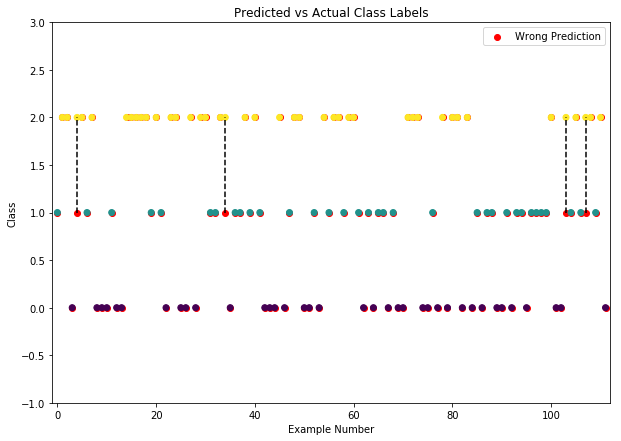

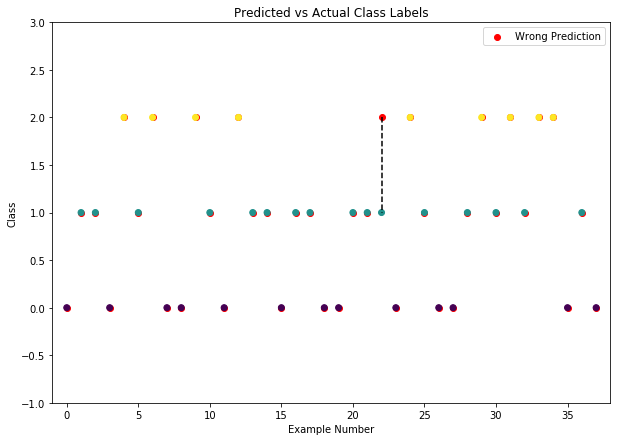

In [36]:
import matplotlib.pyplot as plt

def get_lines(indices, Y_pred, Y):
    lines = []
    for i in indices :
        if Y_pred[i] != Y[i] :
            line = [[i, i], [Y_pred[i], Y[i]]]
            lines.append(line)
    return lines

indices = np.arange(len(Y_train))
Y_train_pred = predict(X_train, tree_dict)
plt.figure(figsize = (10, 7))
plt.title("Predicted vs Actual Class Labels")
plt.axis((-1,len(X_train), -1, len(class_dict)))
plt.scatter(indices, Y_train_pred, c = 'r', label = "Wrong Prediction")
plt.scatter(indices, Y_train, c = Y_train)
plt.xlabel("Example Number")
plt.ylabel("Class")
lines = get_lines(indices, Y_train_pred, Y_train)

for line in lines:
    line_X = line[0]
    line_Y = line[1]
    plt.plot(line_X, line_Y, c = 'black', linestyle = "dashed")
    
plt.legend()
plt.show()

indices = np.arange(len(Y_test))

Y_test_pred = predict(X_test, tree_dict)
plt.figure(figsize = (10, 7))
plt.title("Predicted vs Actual Class Labels")
plt.axis((-1,len(X_test), -1, len(class_dict)))
plt.scatter(indices, Y_test_pred, c = 'r', label = "Wrong Prediction")
plt.scatter(indices, Y_test, c = Y_test)
plt.xlabel("Example Number")
plt.ylabel("Class")
lines = get_lines(indices, Y_test_pred, Y_test)

for line in lines:
    line_X = line[0]
    line_Y = line[1]
    plt.plot(line_X, line_Y, c = 'black', linestyle = "dashed")
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix for Y_train\n", confusion_matrix(Y_train, Y_train_pred))
print("Confusion Matrix for Y_test\n", confusion_matrix(Y_test, Y_test_pred))

Confusion Matrix for Y_train
 [[37  0  0]
 [ 0 34  0]
 [ 0  4 37]]
Confusion Matrix for Y_test
 [[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


In [38]:
# Level order traversal

def print_node(node):
    for key, val in node.items() :
        if not isinstance(val, dict) :
            print(key, ":", val)
    
def print_tree_level_order(tree_dict):
    from collections import deque
    q = deque([tree_dict])
    while len(q)!= 0 :
        node = q.popleft()
        print("*" * 100)
        print("Len", len(q))
        print("*" * 100)
        if 0 in node.keys() :
            q.append(node[0])
            
        if 1 in node.keys() :
            q.append(node[1])
        print_node(node)

print_tree_level_order(tree_dict)



****************************************************************************************************
Len 0
****************************************************************************************************
level : 0
Entropy : 1.09567141291
predict_class : 2
num_of_examples : 112
is_leaf : False
selected_feature : sepal width (cm)
selected_feature_index : 1
max_info_gain : 0.917863978566
best_split_mid_value : 2.95
****************************************************************************************************
Len 1
****************************************************************************************************
level : 1
Entropy : 0.831442898105
predict_class : 1
num_of_examples : 45
is_leaf : False
selected_feature : sepal length (cm)
selected_feature_index : 0
max_info_gain : 0.6496226158
best_split_mid_value : 4.7
****************************************************************************************************
Len 2
*******************************************************

### PyDotPlus Documentation Reference
http://pydotplus.readthedocs.io/reference.html

In [73]:
import pydotplus as dot
"""
level 0
class_counts setosa 37
versicolor 34
virginica 41
Entropy 1.09567141291
is_leaf False
selected_feature sepal width (cm)
selected_feature_index 1
max_info_gain 0.917863978566
best_split_mid_value 2.95
num_of_examples 112
"""

"""
Node Values (in sklearn)
petal width (cm) <= 0.75
gini = 0.663
samples = 112
value = [39, 41, 32]
class = versicolor
"""
def get_node_data(node, class_dict):
    data = ""
    if not node['is_leaf'] :
        data += node['selected_feature'] + " <= " + str(node['best_split_mid_value']) + "\n"
        data += "Gain = " + str(node['max_info_gain']) + "\n"
    data += "entropy = " + str(node['Entropy']) + "\n"
    data += "samples = " + str(node['num_of_examples']) + "\n"
    value = [0 for i in range(len(class_dict))]
    for index, name in class_dict.items():
        if name in node["class_counts"] :
            value[index] = (node["class_counts"][name])
    data += "value = " + str(value) + "\n"
    data += "class = " + class_dict[node['predict_class']]
        
    return data

def get_custom_node(node_label, is_leaf):

    node = dot.Node(label = node_label)
    
    """    Add Size, color and text according to "is_leaf" value    """
    if is_leaf :
        node.set_fillcolor('greenyellow')
        node.set_style('bold')
        node.set_shape('ellipse')
    else :
        node.set_fillcolor('lavender')
        node.set_shape('box')
    return node

"""
def get_decision_tree_graph(tree_dict, class_dict):
    graph = dot.Dot(graph_type = "digraph")
    from collections import deque
    q = deque([tree_dict])
    while len(q)!= 0 :
        node = q.popleft()
        parent_node = get_custom_node(get_node_data(node, class_dict), node['is_leaf'])
        graph.add_node(parent_node)
        if 0 in node.keys() :
            q.append(node[0])
            child_0_data = get_node_data(node[0], class_dict)
            child_0_node = get_custom_node(child_0_data, node[0]['is_leaf'])
            graph.add_node(child_0_node)
            edge = dot.Edge(parent_node, child_0_node)
            graph.add_edge(edge)
            
        if 1 in node.keys() :
            q.append(node[1])
            child_1_data = get_node_data(node[1], class_dict)
            child_1_node = get_custom_node(child_1_data, node[1]['is_leaf'])
            graph.add_node(child_1_node)
            edge = dot.Edge(parent_node, child_1_node)
            graph.add_edge(edge)
    return graph
"""
def get_decision_tree_graph(tree_dict, class_dict):
    graph = dot.Dot(graph_type = "digraph")
    
    from collections import deque
    q = deque([tree_dict])
    
    while len(q)!= 0 :
        node = q.popleft()
        parent_data = get_node_data(node, class_dict)
        parent_node = get_custom_node(parent_data, node['is_leaf'])
        #graph.add_node(parent_node)
        if 0 in node.keys() :
            q.append(node[0])
            child_0_data = get_node_data(node[0], class_dict)
            child_0_node = get_custom_node(child_0_data, node[0]['is_leaf'])
            #graph.add_node(child_0_node)
            edge = dot.Edge(parent_data, child_0_data, label = True)
            graph.add_edge(edge)
            
        if 1 in node.keys() :
            q.append(node[1])
            child_1_data = get_node_data(node[1], class_dict)
            child_1_node = get_custom_node(child_1_data, node[1]['is_leaf'])
            #graph.add_node(child_1_node)
            edge = dot.Edge(parent_data, child_1_data, label = False)
            graph.add_edge(edge)
    return graph


graph = get_decision_tree_graph(tree_dict, class_dict)

graph.write_png("iris_dataset_decision_tree.png")

True